# Branching Out into Isolation Forests

### Tree Based Anomaly Detection

Stephanie Kirmer

ChiPy October 2020

In [1]:
import numpy as np
import pandas as pd
import logging as log
import os
import datetime
import typing
from typing import Callable, List
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Spectral6, brewer
from bokeh.transform import linear_cmap, factor_cmap

# Load data 

From Kaggle - tracks on Spotify

https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv

Let's identify really unusual tracks!

In [2]:
dataset = pd.read_csv("/Users/skirmer/projects/isolationforests/data/data.csv")

In [3]:
dataset.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


Characteristics of the tracks:

In [4]:
dataset.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

# Feature Engineering

Adding some ratios and scaled versions of some features.

In [5]:
def make_ratios(df: pd.DataFrame, featurenames: List[List]):
    ''' Accepts a list of lists (pairs of columns) to be ratioed. Returns the original dataframe with new columns representing ratios of features appended to end.'''

    for i in featurenames:
        df[f'ratio_{i[0]}_{i[1]}'] = df[i[0]]/df[i[1]]
        log.info('Added new feature:' + f'ratio_{i[0]}_{i[1]}')
    return(df)

In [6]:
dataset2 = make_ratios(dataset, featurenames = [['energy', 'acousticness'],
                                                ['loudness', 'acousticness'],
                                                ['instrumentalness', 'acousticness'],
                                                ['liveness', 'acousticness'],
                                                ['danceability', 'explicit'],
                                                ['popularity', 'tempo'],
                                                ['popularity', 'loudness'],
                                                ['popularity', 'year'],
                                                ['key', 'speechiness'],
                                                ['instrumentalness', 'speechiness']])

In [7]:
dataset2 = dataset2.replace([np.inf, -np.inf], 0)


def scale_all_features(df: pd.DataFrame):
    rdf = df.select_dtypes(include='number')
    rdf2 = pd.DataFrame(minmax_scale(rdf))
    rdf2.columns = [f'{x}_scaled' for x in rdf.columns]
    rdf3 = pd.concat([df.reset_index(drop=True), rdf2], axis=1)
    return(rdf3)

dataset2 = scale_all_features(dataset2)

dataset2['year_bin'] = pd.cut(dataset2['year'],9)

In [8]:
dataset2['year_bin'].value_counts(normalize=True) * 100


(1998.0, 2009.0]      12.948108
(1987.0, 1998.0]      12.948108
(1976.0, 1987.0]      12.948108
(1965.0, 1976.0]      12.948108
(1954.0, 1965.0]      12.948108
(2009.0, 2020.0]      12.745646
(1943.0, 1954.0]      11.576197
(1932.0, 1943.0]       6.598826
(1920.901, 1932.0]     4.338793
Name: year_bin, dtype: float64

In [9]:
from plotnine import *
import plotnine.options as pn
from bokeh.plotting import output_file, show

pn.figure_size = (7,3)
# Must downsample to get any reasonable rendering speed
plotset = dataset2.sample(frac=0.15, replace=False, random_state=1)

plotset.shape

(25486, 55)

In [10]:
plotset.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'ratio_energy_acousticness',
       'ratio_loudness_acousticness', 'ratio_instrumentalness_acousticness',
       'ratio_liveness_acousticness', 'ratio_danceability_explicit',
       'ratio_popularity_tempo', 'ratio_popularity_loudness',
       'ratio_popularity_year', 'ratio_key_speechiness',
       'ratio_instrumentalness_speechiness', 'acousticness_scaled',
       'danceability_scaled', 'duration_ms_scaled', 'energy_scaled',
       'explicit_scaled', 'instrumentalness_scaled', 'key_scaled',
       'liveness_scaled', 'loudness_scaled', 'mode_scaled',
       'popularity_scaled', 'speechiness_scaled', 'tempo_scaled',
       'valence_scaled', 'year_scaled', 'ratio_energy_acousticness_scaled',
       'ratio_loudness_acousticness_scaled',
 

In [11]:
a = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'popularity', 'speechiness', 'tempo',
       'valence', 'year']
b = a
dict_feat = [(x, y) for x in a for y in b]


Looking for features that have interesting distributions or differentiation.

In [12]:

newset = []
for i in dict_feat:
    newset.append(
        ggplot(plotset, aes(x=i[0], y=i[1]))
        + theme_bw()
        + geom_point()
        + labs(title = f'{i[0]} x {i[1]}')
    )

output_notebook() 

Loading BokehJS ...

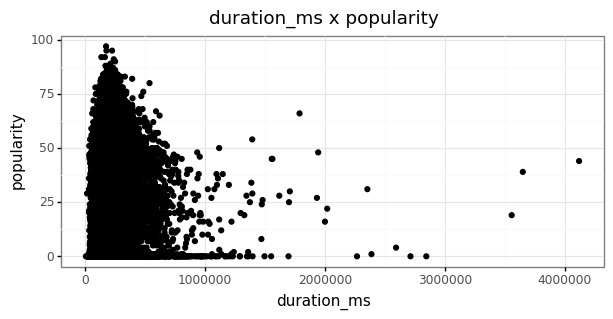

<ggplot: (-9223372036536642823)>

In [13]:
len(newset)
newset[31]

In [14]:
a = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'popularity', 'speechiness', 'tempo',
       'valence', 'year']
b = ['factor(explicit)', 'factor(key)', 'factor(mode)']

dict_feat2 = [(x, y) for x in a for y in b]
dict_feat2

newset2 = []
for i in dict_feat2:
    newset2.append(
        ggplot(plotset, aes(y=i[0], x=i[1]))
        + theme_bw()
        + geom_violin()
        + labs(title = f'{i[0]} x {i[1]}')
    )

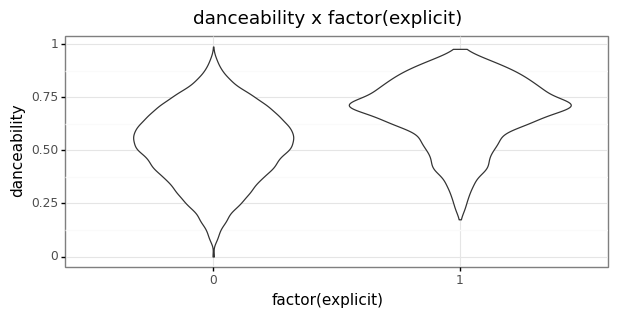

<ggplot: (320908734)>

In [15]:
newset2[3]

* acousticness x key 3 or 5
* dance x explicit 
* dance x energy
* acoustic x year


In [16]:
c = ['ratio_energy_acousticness',
       'ratio_loudness_acousticness', 'ratio_instrumentalness_acousticness',
       'ratio_liveness_acousticness', 'ratio_danceability_explicit',
       'ratio_popularity_tempo', 'ratio_popularity_loudness',
       'ratio_popularity_year', 'ratio_key_speechiness',
       'ratio_instrumentalness_speechiness']

newset3 = []
for i in c:
    newset3.append(
        ggplot(plotset, aes(x=i))
        + theme_bw()
        + geom_density(alpha=0.1)
        + labs(title = i)
    )


/Users/skirmer/Library/Python/3.7/lib/python/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_density : Removed 1 rows containing non-finite values.


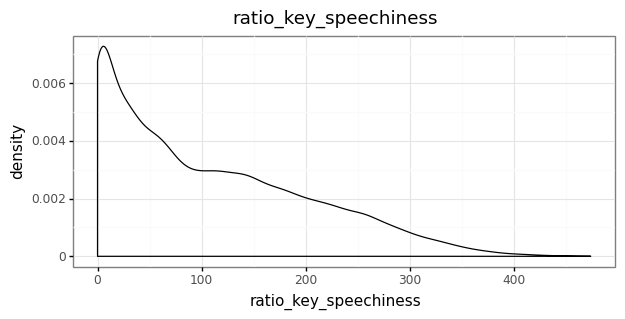

<ggplot: (318348380)>

In [17]:
newset3[8]

In [18]:
features = ['acousticness', 'explicit', 'duration_ms', 'ratio_instrumentalness_speechiness',
            'ratio_popularity_tempo','ratio_popularity_loudness','ratio_popularity_year',
            'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
            'speechiness', 'tempo', 'year']
